In [1]:
import torch
import torch.nn as nn



import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

import torch
import torch.nn as nn
import torchvision.models as models

class CNNBackbone(nn.Module):
    def __init__(self, k=2):
        super(CNNBackbone, self).__init__()
        # Use a pre-trained ResNet as an example backbone
        self.backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the fully connected layers

        # Freeze all layers except the last k layers
        num_layers = len(list(self.backbone.children()))
        for idx, child in enumerate(self.backbone.children()):
            if idx < num_layers - k:
                for param in child.parameters():
                    param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)





import torch
import torch.nn as nn

import torch
import torch.nn as nn

class YOLOHead(nn.Module):
    def __init__(self, in_channels, num_classes, grid_size):
        super(YOLOHead, self).__init__()
        self.num_classes = num_classes
        self.grid_size = grid_size
        print(f"in_channels = {in_channels}")
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, (num_classes + 5) * 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        
       
        # Reshape the output
        batch_size, _, height, width = x.shape
        x = x.view(batch_size, 1, self.num_classes + 5, height, width)
        
        # Split the output into different components
        confidence = x[:, :, 4, :, :]
        
        # Apply sigmoid to confidence
        confidence = torch.sigmoid(confidence)
        
        # Recombine the output
        x = torch.cat((
            x[:, :, :4, :, :],  # box coordinates
            confidence.unsqueeze(2),  # confidence scores
            x[:, :, 5:, :, :]  # class probabilities
        ), dim=2)
        x = x.squeeze(1)

        return x

    

class YOLOInfo:
    def __init__(self, num_classes, grid_size):
        self.num_classes = num_classes
        self.grid_size = grid_size
        self.output_shape = (1, num_classes + 5, grid_size, grid_size)  # Single anchor, so no need for the num_anchors dimension


class YOLOMapper:
    def __init__(self, yolo_info):
        self.yolo_info = yolo_info
        self.region_size = 3

    def labels_to_tensor(self, labels, grid_size=None):
        if grid_size is None:
            grid_size = self.yolo_info.grid_size
        
        output_tensor = torch.zeros((1, self.yolo_info.num_classes + 5, grid_size, grid_size))  # Single anchor

        for label in labels:
            try:
                # Unpack the label
                class_id, x_center, y_center, width, height = label
                
                # Calculate the grid positions
                x_center = x_center * grid_size
                y_center = y_center * grid_size
                width = width * grid_size
                height = height * grid_size
                
                grid_x = int(x_center)
                grid_y = int(y_center)
                class_id = int(class_id)
                
                # Check grid coordinates are within bounds
                if not (0 <= grid_x < output_tensor.shape[3] and 0 <= grid_y < output_tensor.shape[2]):
                    raise ValueError(f"Grid coordinates out of bounds: ({grid_x}, {grid_y})")
                
                # Fill in the tensor for the single anchor
                output_tensor[0, 4, grid_y, grid_x] = 1  # objectness
                output_tensor[0, 5+class_id, grid_y, grid_x] = 1  # class probability
                output_tensor[0, 0, grid_y, grid_x] = x_center - grid_x  # x offset
                output_tensor[0, 1, grid_y, grid_x] = y_center - grid_y  # y offset
                output_tensor[0, 2, grid_y, grid_x] = width
                output_tensor[0, 3, grid_y, grid_x] = height
            
            except Exception as e:
                print(f"Error processing label {label}: {e}")
        
        return output_tensor

    def tensor_to_labels(self, tensor):
        labels = []
        _, channels, grid_size, _ = tensor.shape
        num_classes = channels - 5
        for y in range(grid_size):
            for x in range(grid_size):
                if tensor[0, 4, y, x] > 0.2:  # objectness score check for the single anchor
                    class_id = torch.argmax(tensor[0, 5:, y, x]).item()
                    x_offset = tensor[0, 0, y, x].item()
                    y_offset = tensor[0, 1, y, x].item()
                    width = tensor[0, 2, y, x].item()
                    height = tensor[0, 3, y, x].item()

                    x_center = (x + x_offset) / grid_size
                    y_center = (y + y_offset) / grid_size
                    width /= grid_size
                    height /= grid_size

                    labels.append([class_id, x_center, y_center, width, height])

        return labels


    
    def tensor_to_labels_with_nms(self, tensor, confidence_threshold=0.5, iou_threshold=0.5):
        labels = []
        scores = []
        batch_size, channels, grid_size, _ = tensor.shape
        num_classes = channels - 5  # Assuming 5 for x, y, w, h, and objectness

        for y in range(0, grid_size, self.region_size):
            for x in range(0, grid_size, self.region_size):
                region = tensor[0, :, y:y+self.region_size, x:x+self.region_size]
                
                # Find the cell with maximum objectness in the region
                objectness = region[4].max()
                if objectness > confidence_threshold:
                    max_index = region[4].argmax()
                    print(f"max_index = {max_index}")
                    cell_y, cell_x = max_index // self.region_size, max_index % self.region_size 
                    
                    class_scores = region[5:, min(self.region_size,cell_y), min(self.region_size,cell_x)]
                    class_id = torch.argmax(class_scores).item()
                    class_score = class_scores[class_id].item()
                    
                    # Extract bounding box information
                    bx = (region[0, cell_y, cell_x] + x + cell_x) / grid_size
                    by = (region[1, cell_y, cell_x] + y + cell_y) / grid_size
                    bw = region[2, cell_y, cell_x] / grid_size
                    bh = region[3, cell_y, cell_x] / grid_size

                    labels.append([class_id, bx, by, bw, bh])
                    scores.append(objectness.item() * class_score)

        if not labels:
            return []

        # Convert center-based coordinates to corner-based coordinates
        boxes = torch.tensor([[l[1] - l[3]/2, l[2] - l[4]/2, l[1] + l[3]/2, l[2] + l[4]/2] for l in labels])
        scores = torch.tensor(scores)

        keep = self.non_max_suppression(boxes, scores, iou_threshold)
        
        return [labels[i] for i in keep]

    def non_max_suppression(self, boxes, scores, iou_threshold=0.5):
        if boxes.numel() == 0:
            return []
        
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        areas = (x2 - x1) * (y2 - y1)
        order = scores.argsort(descending=True)

        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                i = order.item()
                keep.append(i)
                break
            else:
                i = order[0].item()
                keep.append(i)

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2 - xx1).clamp(min=0)
            h = (yy2 - yy1).clamp(min=0)

            inter = w * h
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

            inds = (ovr <= iou_threshold).nonzero().squeeze()
            if inds.numel() == 0:
                break
            order = order[inds + 1]

        return keep

    



class YOLOConnection(nn.Module):
    def __init__(self, backbone, yolo_info):
        super(YOLOConnection, self).__init__()
        self.backbone = backbone
        self.yolo_info = yolo_info
        
        # Initialize with a dummy forward pass to get output channels
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            output = self.backbone(dummy_input)
            self.in_channels = output.size(1)

        self.head = YOLOHead(
            in_channels=self.in_channels,
            num_classes=self.yolo_info.num_classes,
            grid_size=self.yolo_info.grid_size
        )

    def forward(self, x):
        features = self.backbone(x)
        predictions = self.head(features)
        return predictions


In [2]:


# Define YOLO info
yolo_info = YOLOInfo(num_classes=3, grid_size=7)

# Initialize backbone and YOLO connection
backbone = CNNBackbone()
yolo_model = YOLOConnection(backbone, yolo_info)

# Initialize YOLO mapper
yolo_mapper = YOLOMapper(yolo_info)

# Example labels

labels = [
[5, 0.1328125, 0.49375, 0.265625, 0.17578125],
[5, 0.65625, 0.75, 0.25, 0.1796875],
[1, 0.77734375, 0.2140625, 0.234375, 0.25546875],
[5, 0.93828125, 0.6265625, 0.1234375, 0.25]
]


# Convert labels to tensor
output_tensor = yolo_mapper.labels_to_tensor(labels)
print("Tensor shape:", output_tensor.shape)

# Convert tensor back to labels
retrieved_labels = yolo_mapper.tensor_to_labels(output_tensor)
print("Retrieved labels:", retrieved_labels)

c:\Users\PC\scoop\apps\python\current\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\scoop\apps\python\current\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


in_channels = 512
Error processing label [5, 0.1328125, 0.49375, 0.265625, 0.17578125]: index 10 is out of bounds for dimension 1 with size 8
Error processing label [5, 0.65625, 0.75, 0.25, 0.1796875]: index 10 is out of bounds for dimension 1 with size 8
Error processing label [5, 0.93828125, 0.6265625, 0.1234375, 0.25]: index 10 is out of bounds for dimension 1 with size 8
Tensor shape: torch.Size([1, 8, 7, 7])
Retrieved labels: [[1, 0.77734375, 0.2140624991485051, 0.234375, 0.2554687431880406], [0, 0.0, 0.42857142857142855, 0.0, 0.0], [0, 0.8571428571428571, 0.5714285714285714, 0.0, 0.0], [0, 0.5714285714285714, 0.7142857142857143, 0.0, 0.0]]


In [3]:


# Create a dummy input tensor (batch size of 1, 3 channels, 224x224 image)
dummy_input = torch.randn(2, 3, 224, 224)

# Pass the dummy input through the model
output = yolo_model(dummy_input)

# Print the shape of the output
print("Output shape:", output.shape)


Output shape: torch.Size([2, 8, 7, 7])


In [4]:
import torch
import torch.nn as nn

class YOLOLoss(nn.Module):
    def __init__(self, S, C, coord_scale=1.0, object_scale=1.0, noobject_scale=0.1, class_scale=1.0):
        super(YOLOLoss, self).__init__()
        self.S = S
        self.C = C
        self.coord_scale = coord_scale
        self.object_scale = object_scale
        self.noobject_scale = noobject_scale
        self.class_scale = class_scale
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, predictions, target):
        batch_size = predictions.size(0)
        grid_size = predictions.size(2)
        
        # Reshape predictions to expected dimensions: (batch_size, 5 + num_classes, grid_size, grid_size)
        predictions = predictions.view(batch_size, 5 + self.C, grid_size, grid_size)

        # Extract predicted components
        coord_pred = predictions[:, :2]  # x, y
        objectness_pred = predictions[:, 4:5]
        class_pred = predictions[:, 5:]

        # Extract target components
        coord_target = target[:, :2]
        objectness_target = target[:, 4:5]
        class_target = target[:, 5:]

        # Masks
        noobj_mask = (objectness_target == 0).float()
        obj_mask = (objectness_target > 0).float()

        # Compute loss components
        loss_coord = self.coord_scale * self.mse_loss(coord_pred * obj_mask, coord_target * obj_mask)
        loss_objectness = self.object_scale * self.bce_loss(objectness_pred, objectness_target)
        loss_class = self.class_scale * self.ce_loss(class_pred * obj_mask, class_target * obj_mask)

        # No-objectness loss
        loss_noobj = self.noobject_scale * self.bce_loss(objectness_pred * noobj_mask, torch.zeros_like(objectness_pred * noobj_mask))

        # Total loss
        total_loss = loss_coord + loss_objectness + loss_class + loss_noobj

        return total_loss

In [5]:
import os

class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, yolo_mapper, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.yolo_mapper = yolo_mapper
        self.transform = transform
        self.image_filenames = sorted(os.listdir(images_dir))
        self.label_filenames = sorted(os.listdir(labels_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
        with open(label_path, 'r') as f:
            labels = [list(map(float, line.strip().split())) for line in f]
        
        label_tensor = self.yolo_mapper.labels_to_tensor(labels)
        return image, label_tensor


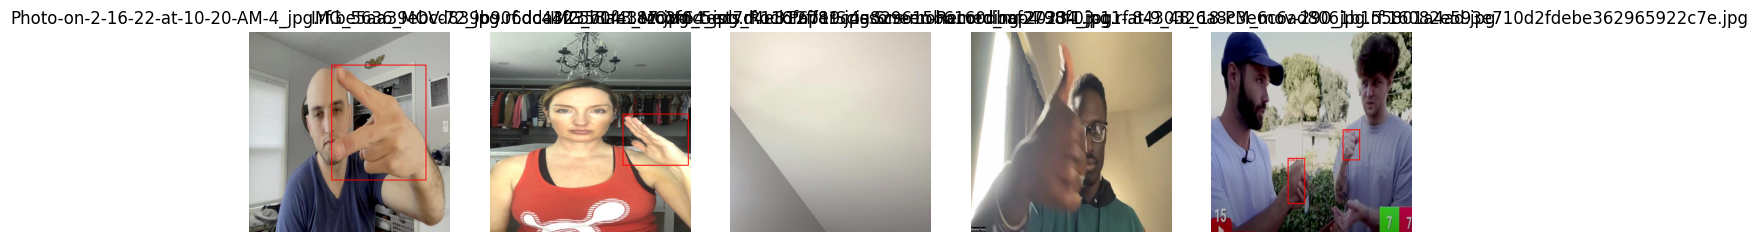

In [6]:
import os
import random
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

class YOLOVisualizer:
    def __init__(self, label_dir, image_dir, grid_size=7, num_classes=20):
        self.label_dir = label_dir
        self.image_dir = image_dir
        self.grid_size = grid_size
        self.num_classes = num_classes

    def load_labels(self, label_path):
        with open(label_path, 'r') as file:
            labels = []
            for line in file.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                labels.append([int(class_id), x_center, y_center, width, height])
        return labels

    def draw_boxes(self, image_path, labels):
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image)
        img_width, img_height = image.size

        for label in labels:
            class_id, x_center, y_center, width, height = label
            # Convert YOLO format to bounding box coordinates
            x1 = (x_center - width / 2) * img_width
            y1 = (y_center - height / 2) * img_height
            x2 = (x_center + width / 2) * img_width
            y2 = (y_center + height / 2) * img_height

            # Draw rectangle and label
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1), f'Class {class_id}', fill="red")

        return image

    def visualize_random_images(self, k=5):
        # Get list of images and labels
        image_files = [f for f in os.listdir(self.image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        label_files = [f.replace('.jpg', '.txt').replace('.png', '.txt') for f in image_files]

        # Randomly select k images
        selected_indices = random.sample(range(len(image_files)), k)
        selected_images = [image_files[i] for i in selected_indices]
        selected_labels = [label_files[i] for i in selected_indices]

        # Plot the selected images with bounding boxes
        plt.figure(figsize=(15, 10))
        for i in range(k):
            image_path = os.path.join(self.image_dir, selected_images[i])
            label_path = os.path.join(self.label_dir, selected_labels[i])
            labels = self.load_labels(label_path)

            image_with_boxes = self.draw_boxes(image_path, labels)

            plt.subplot(1, k, i + 1)
            plt.imshow(image_with_boxes)
            plt.axis('off')
            plt.title(selected_images[i])

        plt.show()

# Example Usage
label_dir = "Rock Paper Scissors SXSW.v14i.yolov8\\train\\labels"
image_dir = "Rock Paper Scissors SXSW.v14i.yolov8\\train\\images"

visualizer = YOLOVisualizer(label_dir, image_dir)
visualizer.visualize_random_images(k=5)


In [7]:
from tqdm import tqdm
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def train_yolo_model(images_dir, labels_dir, yolo_model, yolo_mapper, num_epochs=10, batch_size=8, learning_rate=0.001, save_path='yolo_model.pth'):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = CustomDataset(images_dir, labels_dir, yolo_mapper, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    optimizer = optim.Adam(yolo_model.parameters(), lr=learning_rate)
    criterion = YOLOLoss(S=yolo_info.grid_size, C=yolo_mapper.yolo_info.num_classes)

    yolo_model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit='batch') as pbar:
            for images, labels in dataloader:
                images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                labels = labels.squeeze(1)  # Remove the extra dimension
                
                optimizer.zero_grad()
                outputs = yolo_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                
                # Update the progress bar
                pbar.set_postfix({'Loss': epoch_loss / (pbar.n + 1)})
                pbar.update(1)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
        torch.save(yolo_model.state_dict(), f"{save_path}_epoch{epoch+1}.pth")
        print(f"Model saved as {save_path}_epoch{epoch+1}.pth")

    print("Training complete!")


In [8]:
# Define YOLO info
yolo_info = YOLOInfo(num_classes=3, grid_size=7)

# Initialize backbone and YOLO connection
backbone = CNNBackbone()  # Define CNNBackbone according to your architecture
yolo_model = YOLOConnection(backbone, yolo_info)
yolo_model = yolo_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Initialize YOLO mapper
yolo_mapper = YOLOMapper(yolo_info)



c:\Users\PC\scoop\apps\python\current\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\scoop\apps\python\current\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


in_channels = 512


In [9]:
import torch
import torch.nn as nn
from torchvision import models

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Count parameters
total, trainable = count_parameters(yolo_model)

print(f"Total parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")

Total parameters: 11,767,496
Trainable parameters: 11,084,424


In [10]:
# Train the model
train_yolo_model(
    images_dir='Rock Paper Scissors SXSW.v14i.yolov8\\train\\images',  # Update with your actual images directory
    labels_dir='Rock Paper Scissors SXSW.v14i.yolov8\\train\\labels',  # Update with your actual labels directory
    yolo_model=yolo_model,
    yolo_mapper=yolo_mapper,
    num_epochs=20,
    batch_size=16,
    learning_rate=0.001,
    save_path='yolo_model'
)

Epoch 1/20: 100%|██████████| 403/403 [16:40<00:00,  2.48s/batch, Loss=0.0502]


Epoch [1/20], Loss: 0.0502
Model saved as yolo_model_epoch1.pth


Epoch 2/20: 100%|██████████| 403/403 [15:57<00:00,  2.38s/batch, Loss=0.0252]


Epoch [2/20], Loss: 0.0252
Model saved as yolo_model_epoch2.pth


Epoch 3/20: 100%|██████████| 403/403 [15:58<00:00,  2.38s/batch, Loss=0.016] 


Epoch [3/20], Loss: 0.0160
Model saved as yolo_model_epoch3.pth


Epoch 4/20: 100%|██████████| 403/403 [16:36<00:00,  2.47s/batch, Loss=0.011]  


Epoch [4/20], Loss: 0.0110
Model saved as yolo_model_epoch4.pth


Epoch 5/20:   9%|▊         | 35/403 [01:31<15:58,  2.61s/batch, Loss=0.00827]


KeyboardInterrupt: 

In [ ]:
yolo_model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import cv2
import os
import numpy as np

# Assuming the YOLO classes are already defined as in your provided code
# YOLOHead, YOLOInfo, YOLOMapper, YOLOConnection classes should be available

# Function to draw bounding boxes
def draw_boxes(image, labels, class_names):
    for label in labels:
        class_id, x_center, y_center, width, height = label
        x_center, y_center, width, height = x_center * image.shape[1], y_center * image.shape[0], width * image.shape[1], height * image.shape[0]
        x1, y1 = int(x_center - width / 2), int(y_center - height / 2)
        x2, y2 = int(x_center + width / 2), int(y_center + height / 2)
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        class_name = class_names[int(class_id)] if int(class_id) < len(class_names) else f"Class {int(class_id)}"
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

# Main prediction and visualization function
def predict_and_visualize(model, mapper, image_dir, output_dir, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size as needed
        transforms.ToTensor(),
    ])

    os.makedirs(output_dir, exist_ok=True)

    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)

        # Convert tensor to labels
        labels = mapper.tensor_to_labels(output)
        # Draw boxes on the image
        cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        result_image = draw_boxes(cv_image, labels, class_names)

        # Save the result
        output_path = os.path.join(output_dir, f"pred_{image_name}")
        cv2.imwrite(output_path, result_image)

        print(f"Processed {image_name}")

# Setup and run
if __name__ == "__main__":

    
    # Load your trained weights here
    # model.load_state_dict(torch.load('path_to_your_weights.pth'))
    
    mapper = YOLOMapper(yolo_info)
    
    # Define your class names
    class_names = ["PAPER", "ROCK", "SISSOR", "class4", "class5", "class6", "class7", "class8", "class9", "class10"]
    
    # Set your image and output directories
    image_dir = "Rock Paper Scissors SXSW.v14i.yolov8/valid/images"
    output_dir = "output"
    predict_and_visualize(yolo_model, mapper, image_dir, output_dir, class_names)

In [ ]:
import os

def check_file(filename):
    incorrect_lines = []
    
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file, start=1):
            elements = line.strip().split()
            if len(elements) != 5:
                incorrect_lines.append((line_number, line.strip()))
    
    return incorrect_lines

def check_and_delete_files(labels_directory, images_directory):
    files_to_delete = []

    # Check all files in the labels directory
    for filename in os.listdir(labels_directory):
        file_path = os.path.join(labels_directory, filename)
        if os.path.isfile(file_path):
            incorrect_lines = check_file(file_path)
            if incorrect_lines:
                print(f"File '{filename}' has lines with incorrect number of elements:")
                for line_number, line in incorrect_lines:
                    print(f"Line {line_number}: {line}")
                files_to_delete.append(filename)

    # Delete incorrect label files and corresponding image files
    for filename in files_to_delete:
        # Delete label file
        label_path = os.path.join(labels_directory, filename)
        if os.path.isfile(label_path):
            os.remove(label_path)
            print(f"Deleted label file: {filename}")

        # Delete corresponding image file
        image_file = os.path.splitext(filename)[0] + '.jpg'  # Assuming image files are .jpg
        image_path = os.path.join(images_directory, image_file)
        if os.path.isfile(image_path):
            os.remove(image_path)
            print(f"Deleted image file: {image_file}")

# Example usage
labels_directory = 'Rock Paper Scissors SXSW.v14i.yolov8/valid/labels'
images_directory = 'Rock Paper Scissors SXSW.v14i.yolov8/valid/images'
check_and_delete_files(labels_directory, images_directory)